# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
import artm

In [3]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\collections.py:442: DeprecationWarning: invalid escape sequence \ 
  """
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\mlab.py:2892: DeprecationWarning: invalid escape sequence \|
  delete = set("""~!@#$%^&*()-=+~\|]}[{';: /?.>,<""")
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:190: DeprecationWarning: invalid escape sequence \S
  """
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\mathtext.py:78: DeprecationWarning: invalid escape sequence \p
  """
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\mathtext.py:442: DeprecationWarning: invalid escape sequence \s
  """
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\mathtext.py:756: DeprecationWarning: invalid escape sequence \l
  for alias, target in [('\leftparen', '('),
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\mathtext.py:1041: DeprecationWarning: invalid escape sequence \{
  fixes = {'\{': '{', '\}': '}', 

In [4]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [5]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
                                        batch_size=500)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [6]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, seed=1,
                       num_document_passes=1, reuse_theta=True, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [7]:
# Ваш код
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [8]:
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [9]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=1e5, dictionary=dictionary, class_ids='text', 
                                                            topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [12]:
topic_names2 = topic_names.copy()
topic_names2.remove('bcg')

In [13]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2', tau=-1e5, dictionary=dictionary, class_ids='text', 
                                                            topic_names=topic_names2))

Выполните еще 15 проходов по коллекции.

In [14]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [15]:
# Ваш код
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    tokens = model_artm.score_tracker["top_words"].last_tokens
    authors = model_artm.score_tracker["top_authors"].last_tokens
    print(tokens[topic_name])
    print(authors[topic_name])

sbj0: 
['частица', 'взаимодействие', 'физика', 'кварк', 'симметрия', 'элементарный', 'нейтрино', 'стандартный', 'материя', 'протон', 'бозон', 'заряд', 'масса', 'ускоритель', 'слабый']
['Дмитрий_Казаков', 'Михаил_Данилов', 'Сергей_Майоров', 'Виктор_Брагута', 'Павел_Пахлов', 'Игорь_Волобуев', 'Валерий_Рубаков', 'Сергей_Троицкий', 'Лев_Дудко', 'Лев_Беклемишев', 'Анатолий_Лиходед', 'Эдуард_Боос', 'Дэвид_Гросс', 'Сергей_Гашков', 'Жан-Арыс_Джилкибаев']
sbj1: 
['материал', 'температура', 'структура', 'вещество', 'химический', 'соединение', 'свойство', 'поверхность', 'химия', 'давление', 'углерод', 'сверхпроводимость', 'металл', 'применение', 'полимер']
['Артем_Оганов', 'Валерий_Фокин', 'Дмитрий_Паращук', 'Валентин_Ненайденко', 'Евгений_Гудилин', 'Владимир_Пудалов', 'Валентин_Крапошин', 'Дмитрий_Гольберг', 'Иван_Сорокин', 'Наталья_Берлофф', 'Сергей_Морозов', 'Владимир_Комлев', 'Дмитрий_Клинов', 'Евгений_Антипов', 'Вадим_Бражкин']
sbj2: 
['политический', 'государство', 'политика', 'царь', 'парт

['задача', 'данные', 'компьютер', 'сеть', 'программа', 'компьютерный', 'алгоритм', 'интеллект', 'интернет', 'искусственный', 'ошибка', 'обучение', 'вычислительный', 'пользователь', 'разработка']
['Михаил_Бурцев', 'Александр_Беленький', 'Александр_Сафонов', 'Илья_Шкредов', 'Станислав_Протасов', 'Дмитрий_Ветров', 'Макс_Тегмарк', 'Сезар_Идальго', 'Даниэль_Сельва', 'Григорий_Кабатянский', 'Михаил_Киселев', 'Петр_Дружинин', 'Лайман_Пейдж', 'Деметрис_Зейналипур', 'Арчил_Балахванцев']
sbj18: 
['территория', 'словарь', 'восток', 'древний', 'письменность', 'народ', 'китай', 'северный', 'памятник', 'восточный', 'китайский', 'южный', 'письмо', 'население', 'регион']
['Дмитрий_Беляев', 'Кирилл_Бабаев', 'Георгий_Старостин', 'Марк_Ульянов', 'Сергей_Арутюнов', 'Алексей_Лебедев', 'Анна_Дыбо', 'Дмитрий_Худяков', 'Леонид_Григорьев', 'Борис_Иомдин', 'Евгений_Рогожин', 'Галина_Зеленина', 'Светлана_Кузнецова', 'Александр_Мещеряков', 'Галина_Ершова']
sbj19: 
['клетка', 'ген', 'днк', 'белок', 'организм', 'мо

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [16]:
sbj_topic_labels = ["Физика элементарных частиц", "Химия", "История государства", "Социология", "Когнитивистика",
                    "История религий", "Лингвистика, русский язык", "Антропология", "Юриспруденция", "Медицина",
                    "Биология", "Психология",  "История средних веков", "Наука", "Астрономия",
                    "Экономика", "Психология семейной жизни", "Информационные технологии", "История Китая", "Генетика",
                    "Квантовая механика", "Литературоведение", "История революций", "История СССР", "Лингвистика, религиозные тексты",
                    "Теория относительности", "Театр", "Космология", "Кино"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [17]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids="author")

In [18]:
print(theta.shape)
theta.head()

(30, 1728)


,http://postnauka.ru/video/40870,http://postnauka.ru/video/40872,http://postnauka.ru/video/40874,http://postnauka.ru/video/40877,http://postnauka.ru/video/40880,http://postnauka.ru/video/40882,http://postnauka.ru/video/40884,http://postnauka.ru/video/40887,http://postnauka.ru/video/40889,http://postnauka.ru/video/40998,...,http://postnauka.ru/video/9874,http://postnauka.ru/video/9876,http://postnauka.ru/video/9968,http://postnauka.ru/video/9992,http://postnauka.ru/video/9993,http://postnauka.ru/video/9994,http://postnauka.ru/video/9995,http://postnauka.ru/video/9996,http://postnauka.ru/video/9997,http://postnauka.ru/video/9998
sbj0,8.472379e-16,6.052583e-03,3.395375e-16,3.258865e-15,5.235020e-16,8.466225e-02,8.835638e-11,4.786425e-10,3.500959e-13,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
sbj1,2.331516e-06,1.646895e-09,1.750259e-09,0.000000e+00,1.551965e-12,7.639382e-16,3.425913e-03,1.831367e-12,2.178624e-09,3.696820e-16,...,0.000000,0.000000,0.000000,0.0,0.017006,0.0,0.000000,0.052602,0.000000,0.0
sbj2,2.989903e-10,1.351592e-02,5.128640e-02,9.666268e-03,3.956789e-03,9.745926e-09,0.000000e+00,2.356158e-13,2.358616e-02,1.252182e-03,...,0.000000,0.154832,0.160435,0.0,0.000000,0.0,0.000000,0.000000,0.053718,0.0
sbj3,2.770824e-03,1.133779e-01,8.164321e-04,1.732630e-07,2.789526e-10,1.478568e-04,0.000000e+00,2.394310e-02,1.587210e-01,1.334093e-03,...,0.029915,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
sbj4,1.504410e-05,0.000000e+00,9.264436e-05,5.295627e-16,1.783564e-06,3.534983e-10,9.071771e-03,1.860231e-02,1.871328e-09,8.367965e-06,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.021134,0.000000,0.000000,0.0


In [19]:
print(phi_a.shape)
phi_a.head()

(539, 30)


,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Сергей_Демокритов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039043,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Руслан_Смелянский,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039043,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Александр_Апт,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Людмила_Новикова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

C:\Program Files\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


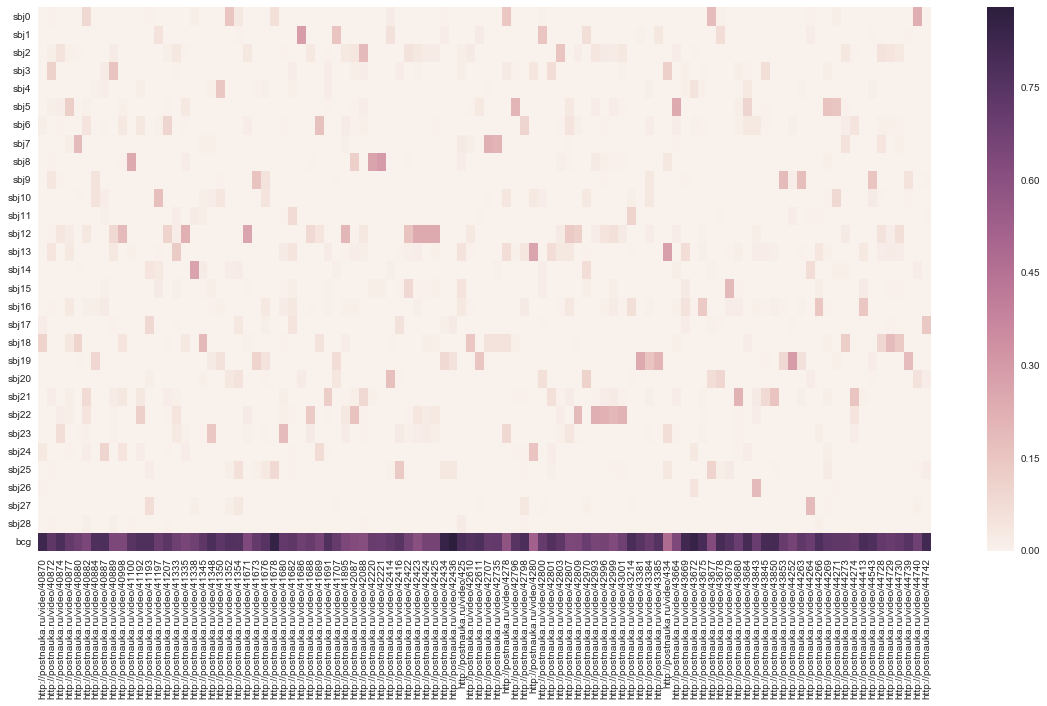

In [20]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:,:100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

<font color="red">sbj13 - "Наука".</font>

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [21]:
# Ваш код
pt = pd.DataFrame(theta.sum(axis=1), columns=["P"])
pt = pt/pt.sum()

In [22]:
pt

,P
sbj0,0.009686
sbj1,0.014895
sbj2,0.009873
sbj3,0.006383
sbj4,0.006586
sbj5,0.006362
sbj6,0.007619
sbj7,0.004716
sbj8,0.008080
sbj9,0.010677


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [23]:
pt2 = pt.copy()
pt2["Topic name"] = topic_labels

In [24]:
pt2.nlargest(7, columns=["P"])

,P,Topic name
bcg,0.661279,Фоновая тема
sbj13,0.049598,Наука
sbj19,0.021599,Генетика
sbj20,0.016723,Квантовая механика
sbj24,0.015168,"Лингвистика, религиозные тексты"
sbj10,0.015114,Биология
sbj14,0.015007,Астрономия


In [25]:
pt2.nsmallest(3, columns=["P"])

,P,Topic name
sbj26,0.003070,Театр
sbj7,0.004716,Антропология
sbj11,0.005468,Психология


Ваш ответ:
5 тем с max p(t):
<font color="red"><p>
sbj19	Генетика<p>
sbj20	Квантовая механика<p>
sbj24	Лингвистика, религиозные тексты<p>
sbj10	Биология<p>
sbj14	Астрономия<p>
</font>

3 темы с min p(t):
<font color="red"><p>
sbj26	Театр<p>
sbj7	Антропология<p>
sbj11	Психология<p>
</font>

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

C:\Program Files\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


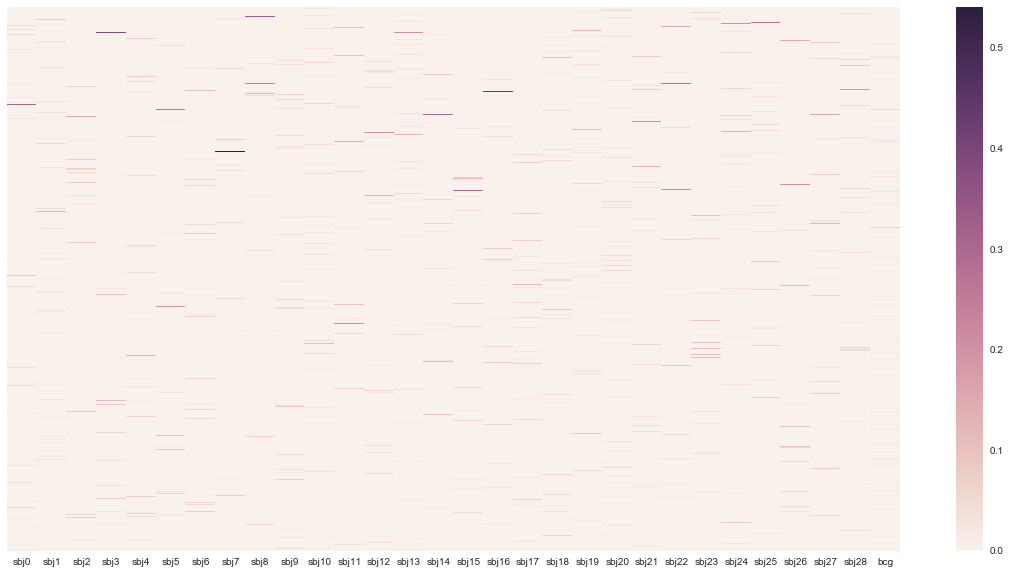

In [26]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [27]:
ta = (phi_a>0.01).sum(axis=1)
ta[ta>=3]

Фёдор_Успенский       4
Илья_Иткин            4
Олег_Ауров            3
Ольга_Вайнштейн       3
Андрей_Журавлев       3
Александр_Пиперски    4
dtype: int64

Ваш ответ:
авторы, значимые в не менее чем 3 темах:
<font color="red"><p>
Фёдор Успенский<p>
Илья Иткин<p>
Олег Ауров<p>
Ольга Вайнштейн<p>
Андрей Журавлев<p>
Александр Пиперски<p>
</font>

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [28]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

C:\Program Files\Anaconda3\lib\site-packages\sklearn\__init__.py:22: DeprecationWarning: invalid escape sequence \.
  module='^{0}\.'.format(re.escape(__name__)))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\joblib\func_inspect.py:53: DeprecationWarning: invalid escape sequence \<
  '\<doctest (.*\.rst)\[(.*)\]\>', source_file).groups()
C:\Program Files\Anaconda3\lib\site-packages\sklearn\externals\joblib\_memory_helpers.py:10: DeprecationWarning: invalid escape sequence \s
  cookie_re = re.compile("coding[:=]\s*([-\w.]+)")
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:330: DeprecationWarning: invalid escape sequence \k
  """
C:\Program Files\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:1533: DeprecationWarning: invalid escape sequence \p
  """
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\omp.py:349: DeprecationWarning: invalid escape sequence \g
  """


In [29]:
# Ваш код
pat_pt = phi_a.mul(pt.T.iloc[0], axis=1)
print(pat_pt.shape)

pa = phi_a.dot(pt)
print(pa.shape)

pta = pat_pt.T.div(pa.T.iloc[0], axis=1).T
print(pta.shape)
pta.head()

(539, 30)
(539, 1)
(539, 30)


,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Сергей_Демокритов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Руслан_Смелянский,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Александр_Апт,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Людмила_Новикова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
model = MDS(n_components=2, random_state=1, dissimilarity="precomputed")
MDS_transformed_cos = model.fit_transform(pairwise_distances(pta, metric="cosine"))
MDS_transformed_cos

array([[ 0.58084744, -0.43862225],
       [-0.57284308, -0.40972627],
       [-0.57284308, -0.40972627],
       ..., 
       [ 0.09873946, -0.47613673],
       [ 0.35521068, -0.64348571],
       [-0.35780581, -0.64353721]])

Визуализируйте найденные двумерные представления с помощью функции scatter. 

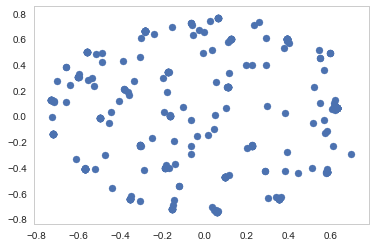

In [31]:
# Ваш код
plt.scatter(MDS_transformed_cos[:, 0], MDS_transformed_cos[:, 1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

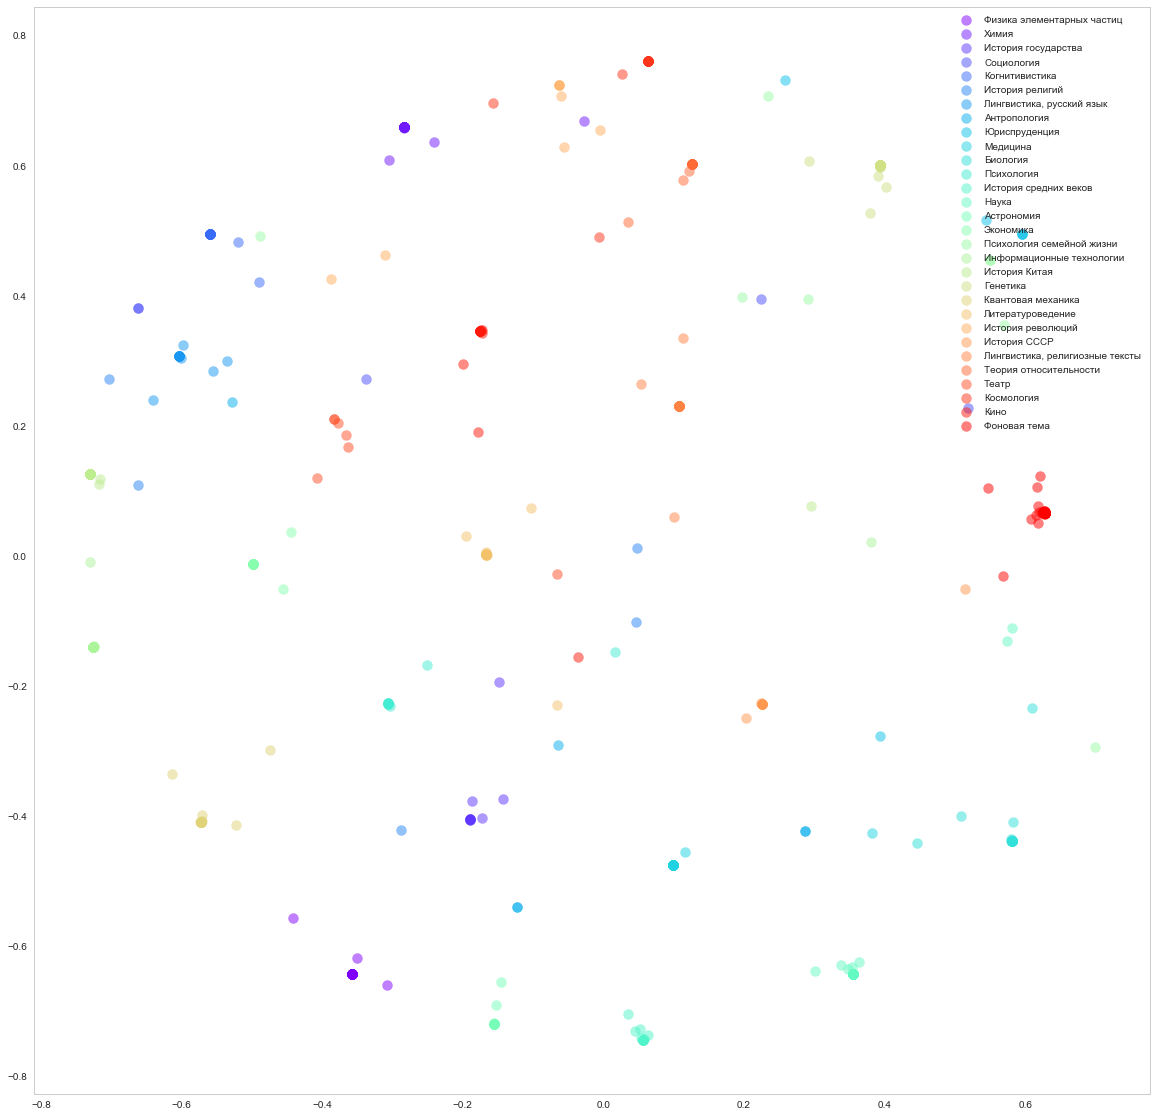

In [32]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
plt.figure(figsize=(20, 20))

max_sbj = pta.values.argmax(axis=1) 

for y, c in zip(range(T), colors):
    plt.scatter(MDS_transformed_cos[max_sbj[:]==y, 0],
                MDS_transformed_cos[max_sbj[:]==y, 1],
                c=c, alpha=0.5, label=topic_labels[y], s=100)

plt.legend()

In [33]:
L = len(MDS_transformed_cos)

MDS_r = np.round(MDS_transformed_cos, decimals = 2)
point_count = {}
shift = np.zeros(L)

for i in range(L):
    t = (MDS_r[i][0], MDS_r[i][1]) 
    if t in point_count:
        shift[i] = point_count[t]
        point_count[t] = point_count[t] + 1
    else:
        point_count[t] = 1

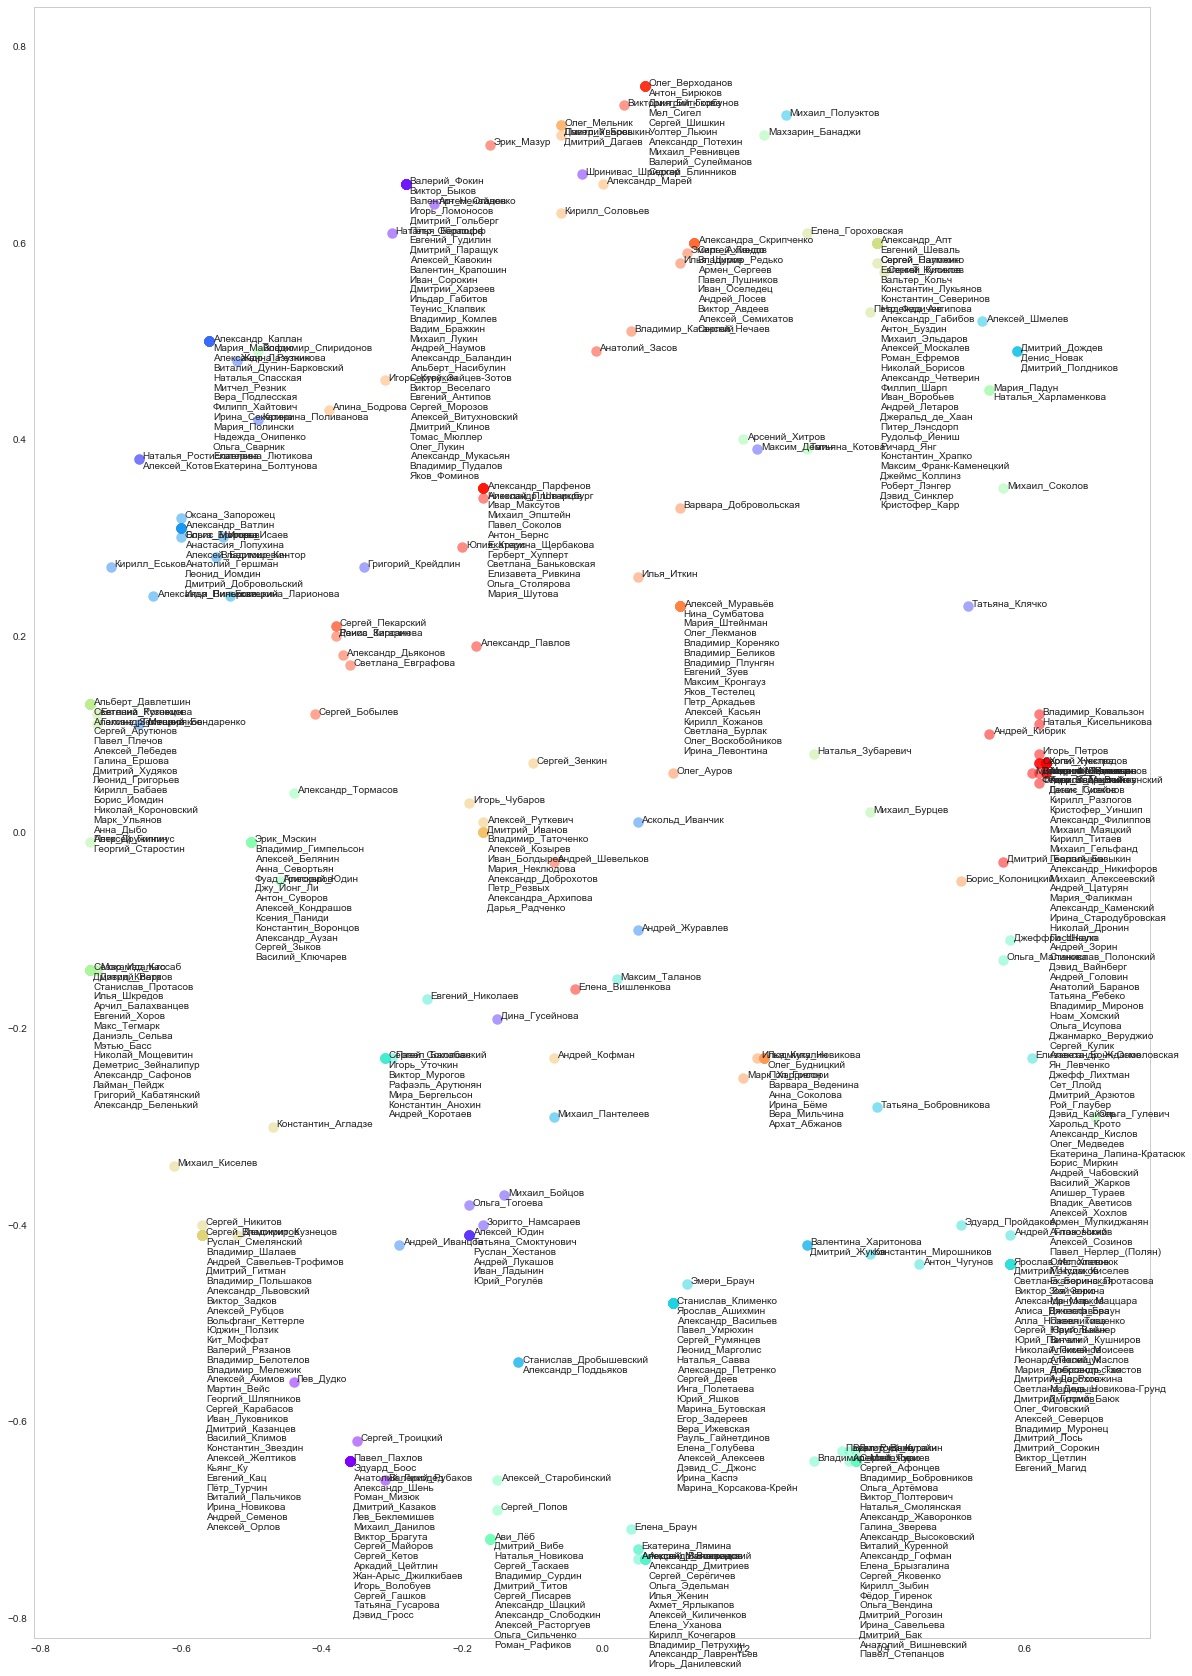

In [34]:
plt.figure(figsize=(20, 30))

for y, c in zip(range(T), colors):
    plt.scatter(MDS_r[max_sbj[:]==y, 0],
                MDS_r[max_sbj[:]==y, 1],
                c=c, alpha=0.5, label=topic_labels[y], s=100)

for i in range(L):
    plt.annotate(pta.axes[0][i], xy=(MDS_r[i, 0], MDS_r[i, 1]),
                 xytext=(MDS_r[i, 0]+0.005, 
                         MDS_r[i, 1]-0.01*shift[i]))

plt.savefig("fig.pdf", format="pdf")

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [35]:
# Ваш код
ts = theta.sum(axis = 1).iloc[0]
pdt = theta.div(ts)
pdt.head()

,http://postnauka.ru/video/40870,http://postnauka.ru/video/40872,http://postnauka.ru/video/40874,http://postnauka.ru/video/40877,http://postnauka.ru/video/40880,http://postnauka.ru/video/40882,http://postnauka.ru/video/40884,http://postnauka.ru/video/40887,http://postnauka.ru/video/40889,http://postnauka.ru/video/40998,...,http://postnauka.ru/video/9874,http://postnauka.ru/video/9876,http://postnauka.ru/video/9968,http://postnauka.ru/video/9992,http://postnauka.ru/video/9993,http://postnauka.ru/video/9994,http://postnauka.ru/video/9995,http://postnauka.ru/video/9996,http://postnauka.ru/video/9997,http://postnauka.ru/video/9998
sbj0,5.062112e-17,3.616323e-04,2.028683e-17,1.947121e-16,3.127842e-17,5.058436e-03,5.279154e-12,2.859813e-11,2.091768e-14,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0
sbj1,1.393044e-07,9.839938e-11,1.045752e-10,0.000000e+00,9.272744e-14,4.564410e-17,2.046929e-04,1.094213e-13,1.301693e-10,2.208792e-17,...,0.000000,0.000000,0.000000,0.0,0.001016,0.0,0.000000,0.003143,0.00000,0.0
sbj2,1.786420e-11,8.075551e-04,3.064281e-03,5.775442e-04,2.364119e-04,5.823036e-10,0.000000e+00,1.407767e-14,1.409236e-03,7.481589e-05,...,0.000000,0.009251,0.009586,0.0,0.000000,0.0,0.000000,0.000000,0.00321,0.0
sbj3,1.655523e-04,6.774150e-03,4.878052e-05,1.035219e-08,1.666698e-11,8.834209e-06,0.000000e+00,1.430562e-03,9.483326e-03,7.970993e-05,...,0.001787,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0
sbj4,8.988609e-07,0.000000e+00,5.535354e-06,3.164053e-17,1.065651e-07,2.112097e-11,5.420240e-04,1.111458e-03,1.118089e-10,4.999727e-07,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.001263,0.000000,0.00000,0.0


In [36]:
N_DOCS = 10
docs = []
for i, row in pdt.iterrows():
    docs.append(row.sort_values(ascending=False).head(N_DOCS).index)
    
pdt2 = pdt.copy()
pdt2["docs"] = docs
pdt2.head()

,http://postnauka.ru/video/40870,http://postnauka.ru/video/40872,http://postnauka.ru/video/40874,http://postnauka.ru/video/40877,http://postnauka.ru/video/40880,http://postnauka.ru/video/40882,http://postnauka.ru/video/40884,http://postnauka.ru/video/40887,http://postnauka.ru/video/40889,http://postnauka.ru/video/40998,...,http://postnauka.ru/video/9876,http://postnauka.ru/video/9968,http://postnauka.ru/video/9992,http://postnauka.ru/video/9993,http://postnauka.ru/video/9994,http://postnauka.ru/video/9995,http://postnauka.ru/video/9996,http://postnauka.ru/video/9997,http://postnauka.ru/video/9998,docs
sbj0,5.062112e-17,3.616323e-04,2.028683e-17,1.947121e-16,3.127842e-17,5.058436e-03,5.279154e-12,2.859813e-11,2.091768e-14,0.000000e+00,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,"Index(['http://postnauka.ru/video/13043', 'htt..."
sbj1,1.393044e-07,9.839938e-11,1.045752e-10,0.000000e+00,9.272744e-14,4.564410e-17,2.046929e-04,1.094213e-13,1.301693e-10,2.208792e-17,...,0.000000,0.000000,0.0,0.001016,0.0,0.000000,0.003143,0.00000,0.0,"Index(['http://postnauka.ru/video/31182', 'htt..."
sbj2,1.786420e-11,8.075551e-04,3.064281e-03,5.775442e-04,2.364119e-04,5.823036e-10,0.000000e+00,1.407767e-14,1.409236e-03,7.481589e-05,...,0.009251,0.009586,0.0,0.000000,0.0,0.000000,0.000000,0.00321,0.0,"Index(['http://postnauka.ru/video/5517', 'http..."
sbj3,1.655523e-04,6.774150e-03,4.878052e-05,1.035219e-08,1.666698e-11,8.834209e-06,0.000000e+00,1.430562e-03,9.483326e-03,7.970993e-05,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,"Index(['http://postnauka.ru/video/2973', 'http..."
sbj4,8.988609e-07,0.000000e+00,5.535354e-06,3.164053e-17,1.065651e-07,2.112097e-11,5.420240e-04,1.111458e-03,1.118089e-10,4.999727e-07,...,0.000000,0.000000,0.0,0.000000,0.0,0.001263,0.000000,0.00000,0.0,"Index(['http://postnauka.ru/video/50793', 'htt..."


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [37]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [38]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [39]:
# Ваш код
for i, row in pdt.iterrows():
    display(HTML("<h3>" + pt2.loc[i]["Topic name"] + "</h3>"))
    display(HTML(", ".join(model_artm.score_tracker["top_words"].last_tokens[i])))
    display(HTML("<ul>"))
    for d in range(N_DOCS):
        display(HTML('<li><a href="' + pdt2.loc[i]["docs"][d] + '">' + pdt2.loc[i]["docs"][d] + '</a></li>'))
    display(HTML("</ul>"))        

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 